INTRODUCTION

The dataset contains measurements of air quality averaged by hour of observation. The data were collected through several sensors of a single device measuring various qualities of the air. The dataset is obtained from a research paper concerned with calibration of such sensors.

We will analyze whether the measurements of hourly averaged Benzene concentrations can be effectively predicted with the measurement values of the other gases/substances from the same multisensor device. The true values of the substances concentrations and other environmental and time variables will also be included in the model.

IMPORTS

In [2]:
!pip install pandas-profiling 
!pip install sklearn-pandas

In [261]:
import pandas as pd
import numpy as np
import os
import random
import warnings
warnings.filterwarnings('ignore')

import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, TimeSeriesSplit
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.preprocessing import StandardScaler, RobustScaler, OneHotEncoder
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn_pandas import DataFrameMapper, gen_features
from sklearn import metrics
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.base import clone

plt.rcParams['figure.figsize'] = 10, 7
plt.style.use('ggplot')

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

COMMONLY USED CONSTANTS

In [34]:
TARGET = 'C6H6(GT)'

FUNCTIONS

In [268]:
def scatterplots(Xvar):
    for i in Xvar:
        figure = plt.figure
        ax = plt.gca()
        ax.scatter(x=df_full[i], y=np.sqrt(df_full[TARGET]))
        ax.set_xlabel(i)
        ax.set_ylabel('Benzene Concentration')
        ax.set_title("Benzene Concentration vs {} Relationship".format(i))
        
        plt.show();

def univariate_regplot(x, y, data):
    ax = sns.regplot(x=x, y=y, data=train)
    ax.set_title(f'{y} and {x} relationship')
    return ax

DATASET PREPARATION

In [4]:
df_full = pd.read_csv(r'C:\Users\1\Desktop\HW_Reg\AirQualityUCI.csv', sep=";")
df_full.head(10)
df_full.shape

,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,Unnamed: 15,Unnamed: 16
0,10/03/2004,18.00.00,"2,6",1360.0,150.0,"11,9",1046.0,166.0,1056.0,113.0,1692.0,1268.0,"13,6","48,9","0,7578",NaN,NaN
1,10/03/2004,19.00.00,2,1292.0,112.0,"9,4",955.0,103.0,1174.0,92.0,1559.0,972.0,"13,3","47,7","0,7255",NaN,NaN
2,10/03/2004,20.00.00,"2,2",1402.0,88.0,"9,0",939.0,131.0,1140.0,114.0,1555.0,1074.0,"11,9","54,0","0,7502",NaN,NaN
3,10/03/2004,21.00.00,"2,2",1376.0,80.0,"9,2",948.0,172.0,1092.0,122.0,1584.0,1203.0,"11,0","60,0","0,7867",NaN,NaN
4,10/03/2004,22.00.00,"1,6",1272.0,51.0,"6,5",836.0,131.0,1205.0,116.0,1490.0,1110.0,"11,2","59,6","0,7888",NaN,NaN
5,10/03/2004,23.00.00,"1,2",1197.0,38.0,"4,7",750.0,89.0,1337.0,96.0,1393.0,949.0,"11,2","59,2","0,7848",NaN,NaN
6,11/03/2004,00.00.00,"1,2",1185.0,31.0,"3,6",690.0,62.0,1462.0,77.0,1333.0,733.0,"11,3","56,8","0,7603",NaN,NaN
7,11/03/2004,01.00.00,1,1136.0,31.0,"3,3",672.0,62.0,1453.0,76.0,1333.0,730.0,"10,7","60,0","0,7702",NaN,NaN
8,11/03/2004,02.00.00,"0,9",1094.0,24.0,"2,3",609.0,45.0,1579.0,60.0,1276.0,620.0,"10,7","59,7","0,7648",NaN,NaN
9,11/03/2004,03.00.00,"0,6",1010.0,19.0,"1,7",561.0,-200.0,1705.0,-200.0,1235.0,501.0,"10,3","60,2","0,7517",NaN,NaN


(9471, 17)

In [ ]:
df_full.tail(115)

Seems like we have two empty columns that bear no value for further analysis.
We can also compare the tail of the dataset with the source Excel file and see that there are 114 extra empty rows to drop. This corresponds with the description of the dataset in which only 9,358 observations and 15 features are declared. 

In [12]:
df_full = df_full.drop(columns=['Unnamed: 15', 'Unnamed: 16'])
df_full = df_full.drop(df_full.tail(114).index)

In [6]:
df_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9471 entries, 0 to 9470
Data columns (total 17 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Date           9357 non-null   object 
 1   Time           9357 non-null   object 
 2   CO(GT)         9357 non-null   object 
 3   PT08.S1(CO)    9357 non-null   float64
 4   NMHC(GT)       9357 non-null   float64
 5   C6H6(GT)       9357 non-null   object 
 6   PT08.S2(NMHC)  9357 non-null   float64
 7   NOx(GT)        9357 non-null   float64
 8   PT08.S3(NOx)   9357 non-null   float64
 9   NO2(GT)        9357 non-null   float64
 10  PT08.S4(NO2)   9357 non-null   float64
 11  PT08.S5(O3)    9357 non-null   float64
 12  T              9357 non-null   object 
 13  RH             9357 non-null   object 
 14  AH             9357 non-null   object 
 15  Unnamed: 15    0 non-null      float64
 16  Unnamed: 16    0 non-null      float64
dtypes: float64(10), object(7)
memory usage: 1.2+ MB


In [7]:
with open(r'C:\Users\1\Desktop\HW_Reg\DS_description.txt') as f:
   ds_info = f.read()
print(ds_info)

Attribute Information:
0 Date (DD/MM/YYYY)
1 Time (HH.MM.SS)
2 True hourly averaged concentration CO in mg/m^3 (reference analyzer)
3 PT08.S1 (tin oxide) hourly averaged sensor response (nominally CO targeted)
4 True hourly averaged overall Non Metanic HydroCarbons concentration in microg/m^3 (reference analyzer)
5 True hourly averaged Benzene concentration in microg/m^3 (reference analyzer)
6 PT08.S2 (titania) hourly averaged sensor response (nominally NMHC targeted)
7 True hourly averaged NOx concentration in ppb (reference analyzer)
8 PT08.S3 (tungsten oxide) hourly averaged sensor response (nominally NOx targeted)
9 True hourly averaged NO2 concentration in microg/m^3 (reference analyzer)
10 PT08.S4 (tungsten oxide) hourly averaged sensor response (nominally NO2 targeted)
11 PT08.S5 (indium oxide) hourly averaged sensor response (nominally O3 targeted)
12 Temperature in Г‚В°C
13 Relative Humidity (%)
14 AH Absolute Humidity



From the description we see that there are only 2 non-numeric features: Date and Time. Several of the rest numeric ones require a delimiter transformation for further analysis and for memory saving purposes.

In [14]:
df_full[['CO(GT)', 'C6H6(GT)', 'T', 'RH', 'AH']] = df_full[['CO(GT)', 'C6H6(GT)', 
                                                            'T', 'RH', 'AH']].apply(lambda x: x.str.replace(',','.')).apply(pd.to_numeric)

In [15]:
df_full[['CO(GT)', 'C6H6(GT)', 'T', 'RH', 'AH']] = df_full[['CO(GT)', 'C6H6(GT)', 
                                                            'T', 'RH', 'AH']].apply(pd.to_numeric)
df_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9357 entries, 0 to 9356
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Date           9357 non-null   object 
 1   Time           9357 non-null   object 
 2   CO(GT)         9357 non-null   float64
 3   PT08.S1(CO)    9357 non-null   float64
 4   NMHC(GT)       9357 non-null   float64
 5   C6H6(GT)       9357 non-null   float64
 6   PT08.S2(NMHC)  9357 non-null   float64
 7   NOx(GT)        9357 non-null   float64
 8   PT08.S3(NOx)   9357 non-null   float64
 9   NO2(GT)        9357 non-null   float64
 10  PT08.S4(NO2)   9357 non-null   float64
 11  PT08.S5(O3)    9357 non-null   float64
 12  T              9357 non-null   float64
 13  RH             9357 non-null   float64
 14  AH             9357 non-null   float64
dtypes: float64(13), object(2)
memory usage: 1.1+ MB


Now let's deal with the time variables. By looking at the Time variable, we can see that there are only hour values, which we can conviniently consider as a cyclical feature. This might be helpful for the model since such approach would correspond with the nature of continous measurements of the parameters. For example, the temperature most likely changes gradually from hour to hour, which is best represented in a cyclical manner. We may assume that the target variable C6H6 has a somewhat similar natural time dynamic. 

In [16]:
df_full.Time.unique()

array(['18.00.00', '19.00.00', '20.00.00', '21.00.00', '22.00.00',
       '23.00.00', '00.00.00', '01.00.00', '02.00.00', '03.00.00',
       '04.00.00', '05.00.00', '06.00.00', '07.00.00', '08.00.00',
       '09.00.00', '10.00.00', '11.00.00', '12.00.00', '13.00.00',
       '14.00.00', '15.00.00', '16.00.00', '17.00.00'], dtype=object)

In [18]:
df_full['Time'] = pd.to_numeric(df_full['Time'].astype(str).str[0:2])
df_full.Time.unique()

array([18, 19, 20, 21, 22, 23,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10,
       11, 12, 13, 14, 15, 16, 17], dtype=int64)

In [43]:
df_full['Time_sin'] = np.sin(df_full.Time*(2.*np.pi/24))
df_full['Time_cos'] = np.cos(df_full.Time*(2.*np.pi/24))

We split the Date variable into 3 different columns to capture any potential trends in the days, months or years separately. And apply the cyclical transformation to the Month variable.

In [22]:
df_full['Day'] = pd.to_numeric(df_full['Date'].astype(str).str[0:2])
df_full['Month'] = pd.to_numeric(df_full['Date'].astype(str).str[3:5])
df_full['Year'] = pd.to_numeric(df_full['Date'].astype(str).str[6::])

In [26]:
df_full['Month_sin'] = np.sin((df_full.Month-1)*(2.*np.pi/12))
df_full['Month_cos'] = np.cos((df_full.Month-1)*(2.*np.pi/12))

In [96]:
df_full.head()

,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),...,T,RH,AH,Time_sin,Time_cos,Day,Month,Year,Month_sin,Month_cos
0,10/03/2004,18,2.6,1360.0,150.0,11.9,1046.0,166.0,1056.0,113.0,...,13.6,48.9,0.7578,-1.000000,-1.836970e-16,10,3,2004,0.866025,0.5
1,10/03/2004,19,2.0,1292.0,112.0,9.4,955.0,103.0,1174.0,92.0,...,13.3,47.7,0.7255,-0.965926,2.588190e-01,10,3,2004,0.866025,0.5
2,10/03/2004,20,2.2,1402.0,88.0,9.0,939.0,131.0,1140.0,114.0,...,11.9,54.0,0.7502,-0.866025,5.000000e-01,10,3,2004,0.866025,0.5
3,10/03/2004,21,2.2,1376.0,80.0,9.2,948.0,172.0,1092.0,122.0,...,11.0,60.0,0.7867,-0.707107,7.071068e-01,10,3,2004,0.866025,0.5
4,10/03/2004,22,1.6,1272.0,51.0,6.5,836.0,131.0,1205.0,116.0,...,11.2,59.6,0.7888,-0.500000,8.660254e-01,10,3,2004,0.866025,0.5


The dataset now looks much cleaner. However, not clean enough.

MISSING VALUES

First of all, we can calculate the proportion of the missing values across the columns to decide on the correct strategy for each of the columns.

In [93]:
total = df_full.isin([-200]).sum().sort_values(ascending=False)
percent = (df_full.isin([-200]).sum()/df_full.isin([-200]).count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
NMHC(GT),8443,0.902319
CO(GT),1683,0.179865
NO2(GT),1642,0.175484
NOx(GT),1639,0.175163
PT08.S5(O3),366,0.039115
AH,366,0.039115
RH,366,0.039115
T,366,0.039115
PT08.S4(NO2),366,0.039115
PT08.S3(NOx),366,0.039115


We can see that mostly the dataset is not critically filled with missing values. However, we have an outstanding column 'NMHC(GT)' which consists of missing values by 90%! It can be dropped from the analysis entirely since it contains relatively little information.

In [98]:
df_full = df_full.drop(['NMHC(GT)'], axis=1)

The rest of the columns contain considerably less missing values. I believe that in the context of this particular time series it is more logical to eliminate the entire rows with the missing values. The logic is that imputing a mean or a median would result in useless piece of information, 'the average temperature in the hospital' that might not be valuable for the particular time period. We also have only 1 year of observations, which does not allow to calculate robust average values for the same time period during the year for imputation. There also seems to be little value in imputation of another constant replacing -200. OVerall, the strategy is an arguable point, but another argument in favor of such approach is that we will only lose ~25% of observations, which is comparable with the largest proportions of the missing values in the considered columns. 

In [112]:
df_full = df_full.replace(-200, np.nan)
df_full = df_full.dropna()

In [114]:
df_full_na.shape

(6941, 21)

In [311]:
df_full.reset_index(drop=True, inplace=True)

In [115]:
6941/9357*100

74.17975846959496

After entirely deleting the observations with the missing values, we still get ~75% of the original data. 

FEATURES CATEGORIZATION

Most of the features are continuous numerical variables except for several ones related to time. We assume that all the time variables are nominal categorical and not ordinal since a) 'Time', 'Day' and 'Month' are cyclical, and b) order in 'Year' would not reflect any potentially useful relationships that cannot be captured within the nominal category.

In [116]:
CATEGORICAL = ['Time', 'Day', 'Month', 'Year']
NUMERICAL = df_full.drop([*CATEGORICAL, 'Date'], axis=1).columns.tolist()
if TARGET in NUMERICAL:
    NUMERICAL.remove(TARGET)

In [200]:
PREDICTORS = CATEGORICAL + NUMERICAL

Also, based on the description we group the variables by their nature: sensor respones, true concentrations, time variables, and other environment variables.

In [144]:
SENSOR_RESPONSES = ['PT08.S1(CO)', 'PT08.S2(NMHC)', 'PT08.S3(NOx)', 'PT08.S4(NO2)', 'PT08.S5(O3)']
TRUE_CONCENTRATIONS = ['CO(GT)', 'NOx(GT)', 'NO2(GT)']
TIME_VARS_Cont = ['Time_sin', 'Time_cos', 'Month_sin', 'Month_cos']
TIME_VARS_Cat = ['Time', 'Day', 'Month', 'Year']
ENVIRONMENT_VARS = ['T', 'AH', 'RH']

EDA

From the report, we can make the following conclusions:
- There are highly correlated features, mainly the correlations of the sensors values
- The target variable is highly correlated with the temperature and humidity values

TARGET VARIABLE ANALYSIS

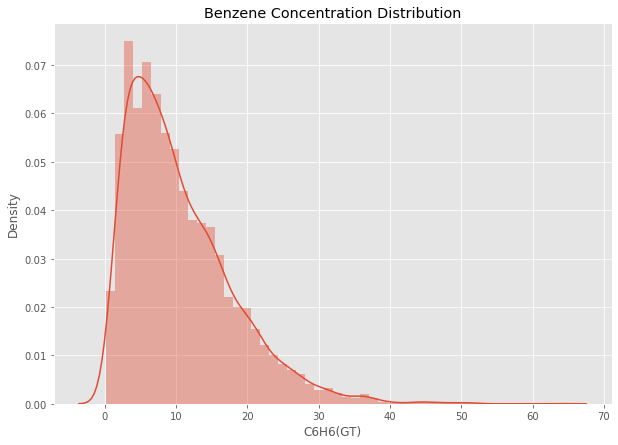

In [120]:
ax = sns.distplot(df_full[TARGET])
ax.set_title('Benzene Concentration Distribution');

The distribution of the target is positively skewed. It might require a transformation to make it look normal. 

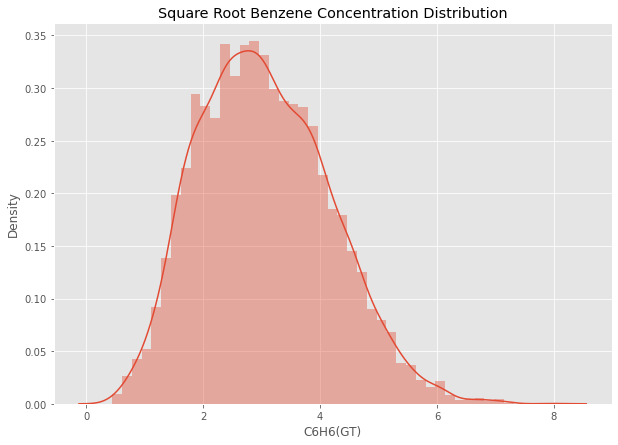

In [244]:
ax = sns.distplot(np.sqrt(df_full[TARGET]), norm_hist=True)
ax.set_title('Square Root Benzene Concentration Distribution');

The distribution looks better for further analysis now. Let's check how the relationship between the transformed target and the predictors.  

BIVARIATE ANALYSIS WITH THE TRANSFORMED TARGET

**SENSOR RESPONSES**

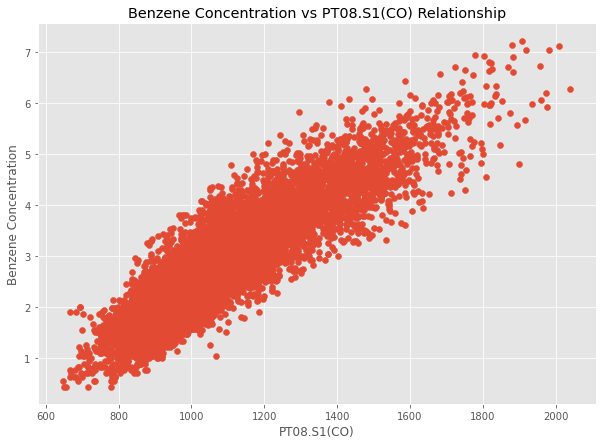

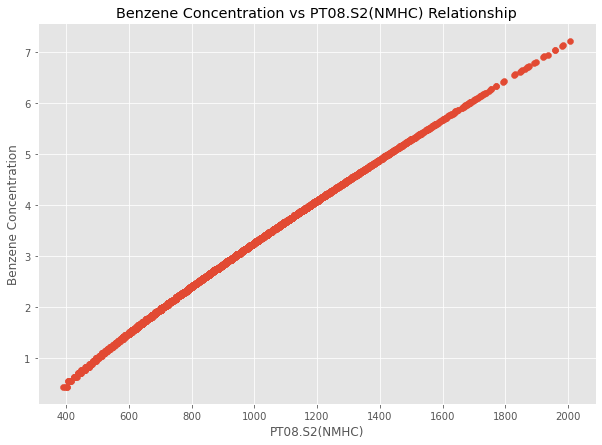

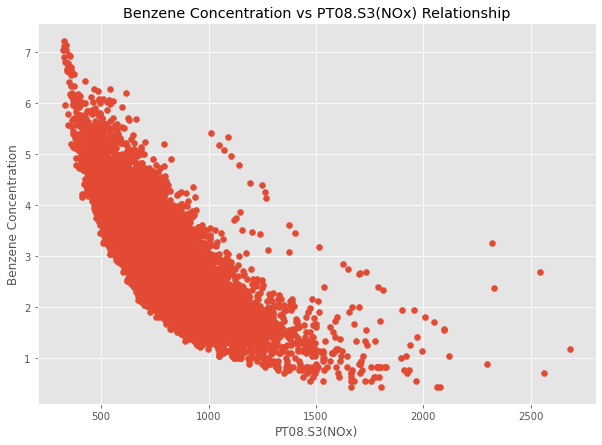

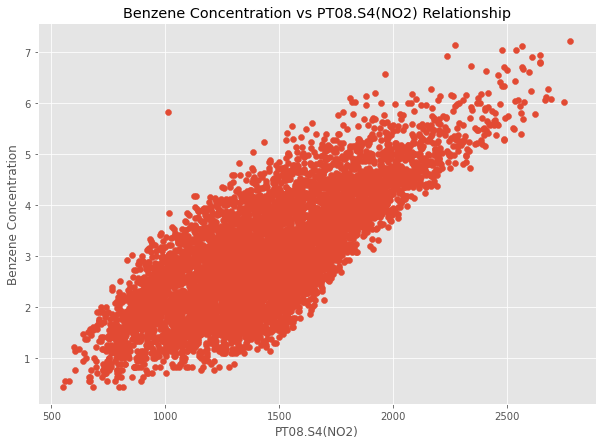

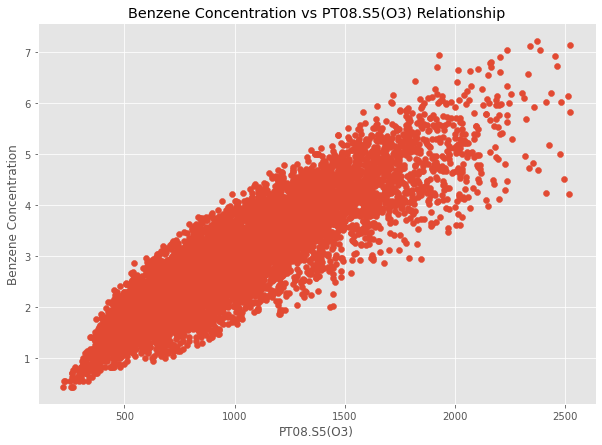

In [270]:
scatterplots(Xvar = SENSOR_RESPONSES)

Overall, the relationships with the sensor predictors are linear $y = bx$, except for the 3rd sensor PT08.03(NOx). Apart from that, the following conclusions can be made:

- S1. There seems to be an obvious outlier. There is also increasing variance, wchich might cause issues related with heteroskedasticity. 
- S2. The relationship is perfectly linear. Perhaps, this sensor was the one that measured Benzene Concentration as a part of the NMHC composite measurement. 
- S3. The relation follows a clear hyperboloid trend $y = b/x$ 
- S4. It can be argued that the relationship is linear. Also several outliers can be noticed.
- S5. We can also see a diverging trend, a potentailly increasing error variance. 

**TRUE CONCENTRATIONS**

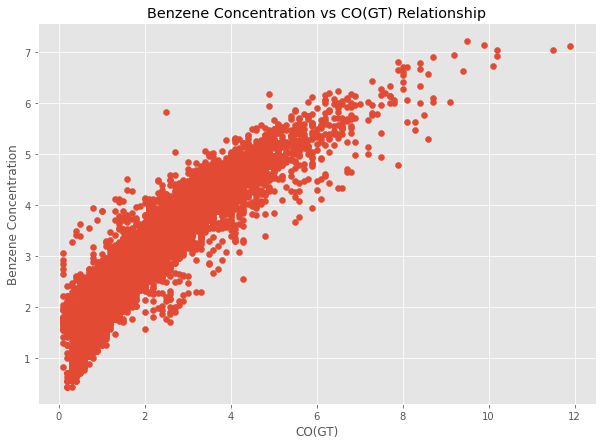

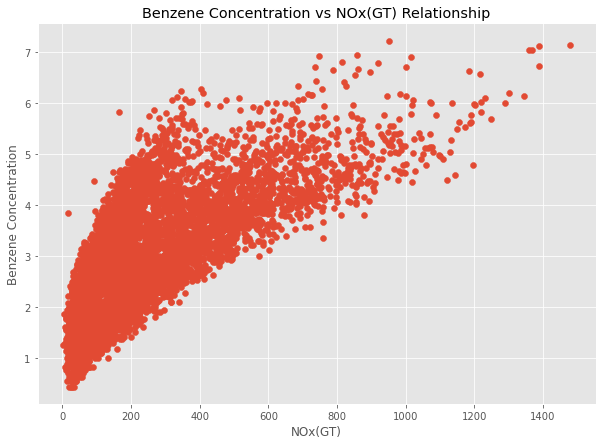

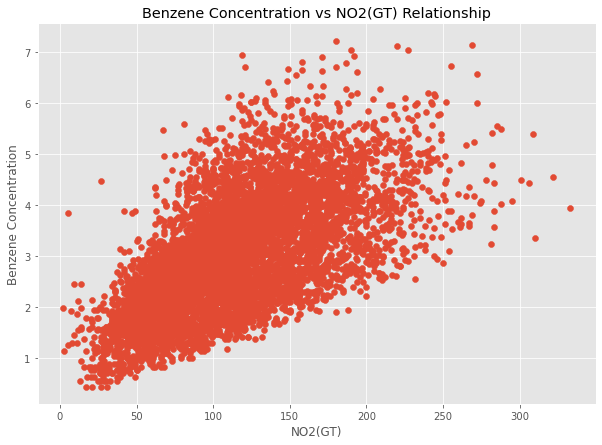

In [271]:
scatterplots(Xvar = TRUE_CONCENTRATIONS)

Generally speaking, CO true concentrations seem to follow a clear linear trend. The relationship with NO & NO2 can also be argued to be fitted well with a linear model, but we can notice potential heteroscedasticity issues. 

**OTHER ENVIRONMENT VARIABLES**

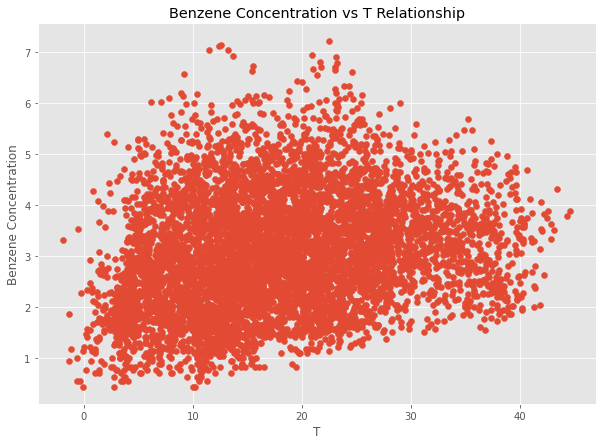

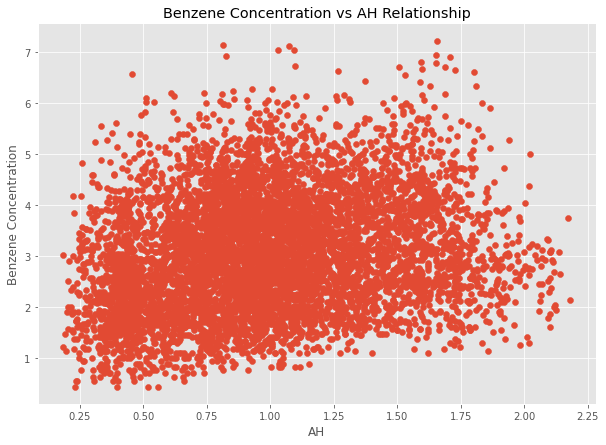

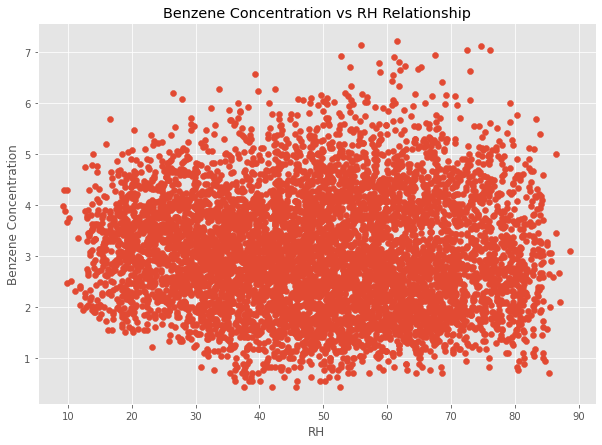

In [272]:
scatterplots(Xvar = ENVIRONMENT_VARS)

At first glance, none of the features shows clear association with the target. However, a detailed look reveales that there might be some slight positive correlation of the target with the temperature and absolute humidity, and negative correlation with the relative humidity.  

**TIME VARIABLES**

CONTINUOUS

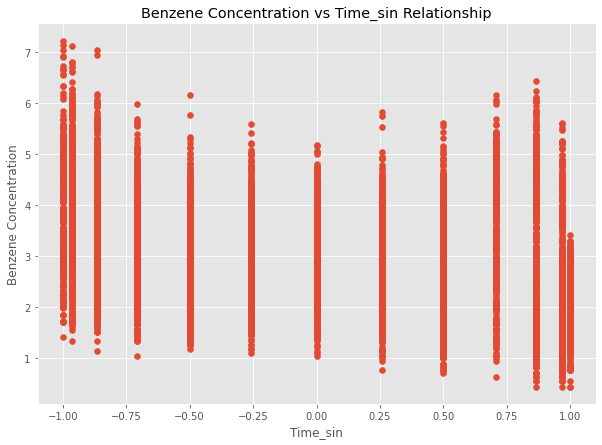

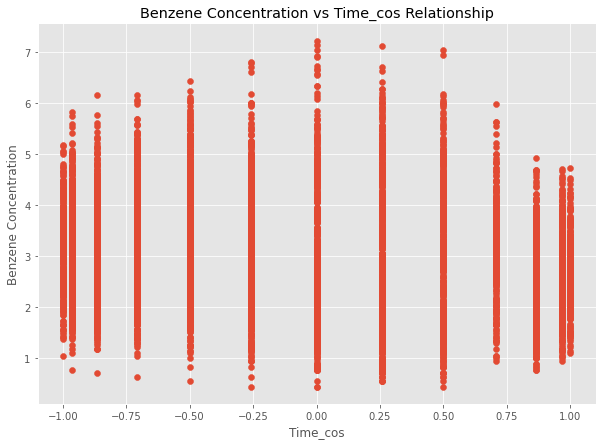

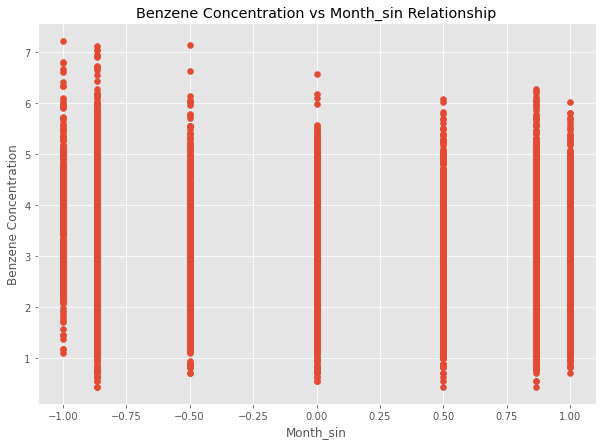

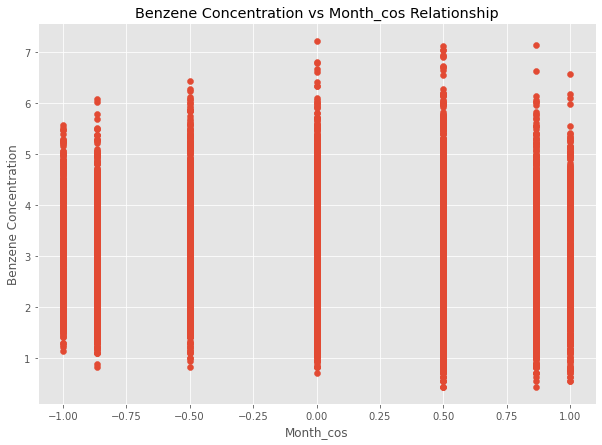

In [273]:
scatterplots(TIME_VARS_Cont)

Here we can observe a slight cyclical nature of the relationship with the target. This might be helpful later in the regression, but overall the relationship does not reveal any clear trends, except for higher variation in certain months and hours.

CATEGORICAL

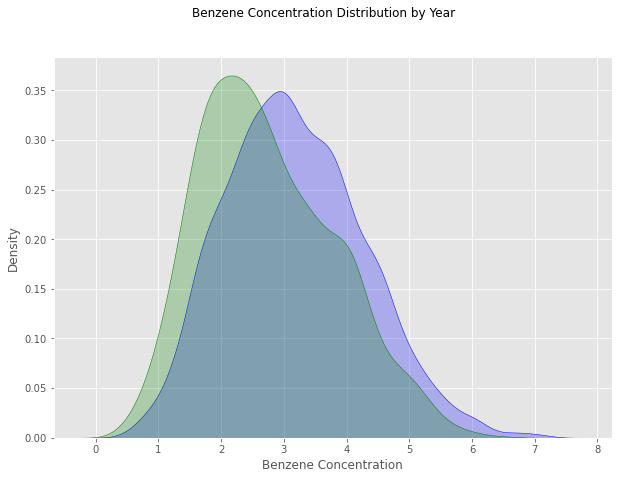

In [274]:
fig, ax = plt.subplots()

sns.kdeplot(np.sqrt(df_full[df_full["Year"]==2004][TARGET]), shade=True, color="blue", label="2004", ax=ax)
sns.kdeplot(np.sqrt(df_full[df_full["Year"]==2005][TARGET]), shade=True, color="green", label="2005", ax=ax)

ax.set_xlabel("Benzene Concentration")
ax.set_ylabel("Density")

fig.suptitle("Benzene Concentration Distribution by Year");

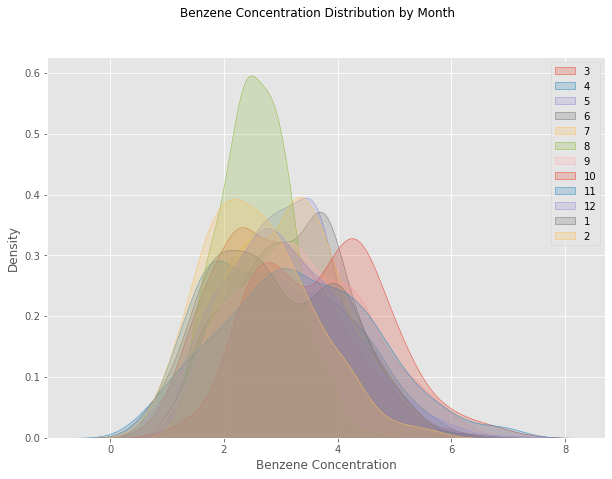

In [275]:
fig, ax = plt.subplots()

for i in df_full['Month'].unique():
    sns.kdeplot(np.sqrt(df_full[df_full["Month"]==i][TARGET]), shade=True, label=i, ax=ax)

ax.set_xlabel("Benzene Concentration")
ax.set_ylabel("Density")
ax.legend()

fig.suptitle("Benzene Concentration Distribution by Month");

As for the time-categorical features, in general we cannot observe clear diverging trends across the categories. 
It can be noticed that the target has a somewhat distinct distribution in August, being fixed in a narrower range of values (concluded from the kurtosis). It can also be argued that the whole distribution of the 2005 year is shifted to higher Benzene concentrations, however, since we lack extensive data for that year or any other longer period, this conclusion would be too bold.

PREDICTORS ANALYSIS

In [245]:
df_full[NUMERICAL].describe().T

,count,mean,std,min,25%,50%,75%,max
CO(GT),6941.0,2.182467,1.441158,0.1000,1.100000,1.900000e+00,2.900000,11.9000
PT08.S1(CO),6941.0,1119.913269,218.733754,647.0000,956.000000,1.085000e+03,1254.000000,2040.0000
PT08.S2(NMHC),6941.0,958.543005,264.055002,390.0000,760.000000,9.310000e+02,1135.000000,2214.0000
NOx(GT),6941.0,250.671949,208.611371,2.0000,103.000000,1.860000e+02,335.000000,1479.0000
PT08.S3(NOx),6941.0,816.893387,251.897200,322.0000,642.000000,7.860000e+02,947.000000,2683.0000
NO2(GT),6941.0,113.874082,47.475017,2.0000,79.000000,1.100000e+02,142.000000,333.0000
PT08.S4(NO2),6941.0,1452.648898,353.301576,551.0000,1207.000000,1.457000e+03,1683.000000,2775.0000
PT08.S5(O3),6941.0,1057.756519,406.509957,221.0000,760.000000,1.006000e+03,1322.000000,2523.0000
T,6941.0,17.755323,8.844909,-1.9000,11.200000,1.680000e+01,23.700000,44.6000
RH,6941.0,48.881905,17.433193,9.2000,35.300000,4.920000e+01,62.200000,88.7000


It is very interesting to check the correlation matrix with this dataset. 

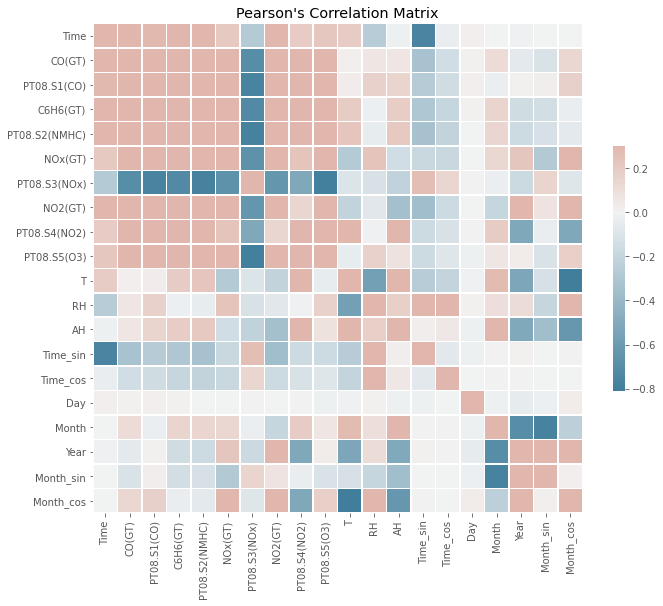

In [250]:
corr = df_full.corr()
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

ax.set_title("Pearson's Correlation Matrix");

Apart from high correlations across the artifically created time-variables, we can notice that the 3rd sensor PT08.S3(NOx) is highly negatively correlated with the target, all the other sensor measurements and the Ground Truth values. There are generally no outstandingly high positive correlations in the dataset. 

OUTLIERS ELIMINATION

By looking at the graphs in the bivariate analysis section, we could detect 2 obvious outliers visually. The one with the target value of >60 is a clear outlier on most of the graphs while the second one appears to be extreme on several of them.

In [312]:
outliers_indx = ((df_full[TARGET] > 50) & (df_full['PT08.S1(CO)'] < 1600))
df_full = df_full.loc[~outliers_indx]

For time saving purposes, I will not analyze distributions of predictors separately. However, visually checking boxplots can also help in outliers detection process.

**PIPELINE**

Firstly, we define the required transformations of the predictor values: applying scaling to the numeric variables and encoding the categorical ones. The missing values have been dealt with in in the MISSING VALUES section. 

In [171]:
numerical_def = gen_features(
    columns=[[c] for c in NUMERICAL],
    classes=[
        {'class': StandardScaler}
    ]
)

categorical_def = gen_features(
    columns=[[c] for c in CATEGORICAL],
    classes=[
        {'class': OneHotEncoder, 'handle_unknown': 'ignore'}
    ]    
)

In [172]:
features = numerical_def + categorical_def
mapper = DataFrameMapper(features)
len(features)

19

TRAIN-TEST SPLIT

For the purposes of cross-validation and final evaluation of the model, the data are split into training and validation subsets. Since the dataset is a time series, TimeSeriesSpit is applied to preserve the sequence of the observations.

In [193]:
target = df_full[TARGET].values

In [314]:
tscv = TimeSeriesSplit(n_splits=5)
for train_index, val_index in tscv.split(target):
    print("TRAIN:", train_index, "TEST:", val_index)

TRAIN: [   0    1    2 ... 1158 1159 1160] TEST: [1161 1162 1163 ... 2314 2315 2316]
TRAIN: [   0    1    2 ... 2314 2315 2316] TEST: [2317 2318 2319 ... 3470 3471 3472]
TRAIN: [   0    1    2 ... 3470 3471 3472] TEST: [3473 3474 3475 ... 4626 4627 4628]
TRAIN: [   0    1    2 ... 4626 4627 4628] TEST: [4629 4630 4631 ... 5782 5783 5784]
TRAIN: [   0    1    2 ... 5782 5783 5784] TEST: [5785 5786 5787 ... 6938 6939 6940]


We will take the last subsets for the **baseline model**.

BASELINE LINEAR MODEL

In [378]:
train_X = df_full[PREDICTORS].iloc[:5784]
train_y = df_full[TARGET].iloc[:5784].values
train_X.shape

(5784, 19)

In [362]:
val_X = df_full[PREDICTORS].iloc[5785:6940]
val_y = df_full[TARGET].iloc[5785:6940].values
val_X.shape

(1154, 19)

In [364]:
train_X_tr = pd.DataFrame(mapper.fit_transform(train_X))
val_X_tr = pd.DataFrame(mapper.transform(val_X))

train_y_tr = pd.Series(np.sqrt(train_y))
val_y_tr = pd.Series(np.sqrt(val_y))

We transform the target variable by taking its square root as discussed in the target analysis section. 

In [366]:
model = LinearRegression().fit(X=train_X_tr, y=train_y_tr)
model.score(val_X_tr, val_y_tr)

-2.9472202578590355e+17

The score is.. too bad. The negative $R^2$ indicates that the regression line seems to fit the data much worse than the horizontal $\bar{y}$.

Let's check the mismatch visually.

In [389]:
predictions = pd.Series(linreg.predict(val_X_tr))
check = pd.concat([predictions, val_y_tr], axis=1)
check.columns = ['Predicted','Actual']

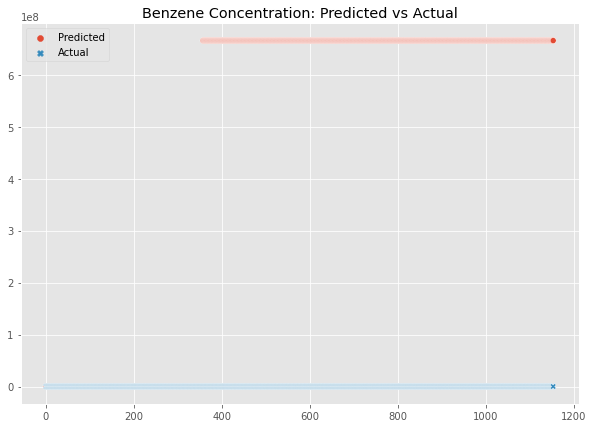

In [390]:
ax = sns.scatterplot(data=check)
ax.set_title("Benzene Concentration: Predicted vs Actual");